In [1]:
import aemeasure
import pandas as pd
import json
import os
import seaborn
import itertools
from random import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

## Load experiment data

In [2]:
experiment_table = aemeasure.read_as_pandas_table("results/be_smart_55it_60sec")
experiment_table

,use_hints,n_concrete,instance,time_limit,iterations,cds_optimize_stop,cds_found_solution_size,cds_proven_optimal,cds_grb_status,cds_global_lb,...,runtime,stdout,stderr,timestamp,hostname,argv,git_revision,python_env,cwd,cds_iter_stop
0,False,20,toybox-case-study-2007-02-13_16-41-51,60.0,55,[],[],[],[],[],...,3.366446,,,2023-03-11T14:25:02.476272,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,None
1,False,224,soletta-case-study-2015-08-19_17-43-58,60.0,55,"[1678541104971, 1678541106130, 1678541106405, ...","[19, 21, 22, 23, 25, 25, 25, 25, 25, 25, 25, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 21, 22, 23, 25, 25, 25, 25, 25, 25, 25, 2...",...,1360.148771,,,2023-03-11T14:47:39.494971,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678541104971, 1678541106130, 1678541106405, ..."
2,False,235,uclibc-case-study-2016-01-02_16-57-03,60.0,55,"[1678541103236, 1678541103260, 1678541107332, ...","[9, 9, 9, 15, 15, 24, 29, 30, 30, 30, 30, 30, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 9, 9, ...","[9, 9, 9, 15, 15, 24, 29, 30, 30, 30, 30, 30, ...",...,1785.247022,,,2023-03-11T14:54:44.590969,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678541103236, 1678541103260, 1678541107332, ..."
3,True,408,busybox-case_study-2007-02-04_17-11-25,60.0,55,"[1678541127079, 1678541130225, 1678541133676, ...","[9, 12, 12, 13, 17, 21, 21, 21, 21, 21, 12, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[9, 12, 12, 13, 17, 21, 21, 21, 21, 21, 21, 21...",...,1705.910597,,,2023-03-11T14:53:25.592139,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678541127079, 1678541130226, 1678541133676, ..."
4,False,458,soletta-case-study-2016-11-22_03-38-15,60.0,55,"[1678541114903, 1678541117424, 1678541120061, ...","[14, 17, 20, 20, 26, 32, 32, 35, 35, 37, 37, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, ...","[14, 17, 20, 20, 26, 32, 32, 35, 35, 37, 37, 3...",...,1588.464606,,,2023-03-11T14:51:32.122058,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678541114903, 1678541117424, 1678541120061, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,True,106,toybox-case-study-2018-10-21_21-55-18,60.0,55,"[1678567185120, 1678567185140, 1678567185235, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 9, 2, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",...,1543.358874,,,2023-03-11T22:05:19.604589,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678567185120, 1678567185140, 1678567185235, ..."
113,False,30,toybox-case-study-2007-12-03_19-28-51,60.0,55,"[1678567156730, 1678567156739, 1678567159978, ...","[6, 6, 8, 8, 8]","[0, 0, 0, 0, 1]","[2, 2, 2, 2, 2]","[6, 6, 8, 8, 8]",...,30.827119,,,2023-03-11T21:39:47.180496,mintbox,ip_hints_experiment.py,265f99a61e383e38590b53ef60fbea21f89a2ac3,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...,"[1678567156730, 1678567156739, 1678

In [3]:
# Load reference data

best_ubs = dict()

with open("lower_bounds_candp.json") as f:
    best_ubs = json.load(f)

best_ubs

{'busybox-case_study-2010-04-18_22-09-30': 21,
 'uclibc-case-study-2010-09-15_12-31-22': 512,
 'busybox-case_study-2010-01-20_02-47-37': 21,
 'busybox-case_study-2008-07-19_09-27-19': 27,
 'soletta-case-study-2016-06-02_14-58-43': 37,
 'soletta-case-study-2015-07-06_15-16-16': 16,
 'busybox-case_study-2008-05-27_08-41-32': 24,
 'busybox-case_study-2008-11-22_18-41-41': 24,
 'uclibc-case-study-2008-10-27_22-02-54': 512,
 'toybox-case-study-2007-11-27_00-57-42': 8,
 'uclibc-case-study-2016-11-27_22-32-11': 310,
 'busybox-case_study-2009-12-07_01-37-34': 21,
 'busybox-case_study-2008-04-22_00-16-29': 24,
 'busybox-case_study-2009-06-18_19-59-51': 24,
 'soletta-case-study-2015-09-02_17-37-27': 30,
 'soletta-case-study-2015-12-28_13-48-28': 30,
 'busybox-case_study-2008-08-22_08-25-26': 27,
 'uclibc-case-study-2016-12-23_07-53-31': 310,
 'soletta-case-study-2016-01-29_14-02-27': 30,
 'busybox-case_study-2008-01-05_03-26-41': 25,
 'busybox-case_study-2008-11-07_01-12-16': 24,
 'soletta-case-

# Create and export Plots

In [4]:
seaborn.set_theme()

In [5]:
datapoints = list()

for instance in experiment_table["instance"].unique():
    rows = experiment_table[experiment_table["instance"] == instance]

    for index, row in rows.iterrows():
        if (len(row["cds_global_lb"]) == 0):
            print("Warning: Entry with empty lists skipped")
            continue
        
        i = 1
        for (global_lb, lb, iter_start, iter_stop, nbhd_start, nbhd_stop, nbhd_size) in zip(row["cds_global_lb"], row["cds_found_solution_size"], row["cds_iter_start"], row["cds_iter_stop"], row["cds_nbhd_start"], row["cds_nbhd_stop"], row["cds_nbhd_free_size"]):
            d = dict()
            d["instance"] = instance
            #d["instance"] = instance.split("-")[0]
            d["iteration"] = i
            d["time in seconds"] = sum(row["cds_iter_stop"][j] - row["cds_iter_start"][j] for j in range(0, i)) / 1000.0
            d["use hints"] = row["use_hints"]
            #d["global cds size"] = global_lb
            d["cds score (% of best known)"] = 100.0 * (global_lb / best_ubs[instance])
            #d["cds size"] = lb
            #d["nbhd_time"] = (nbhd_stop - nbhd_start) / 1000.0
            #d["ip_time"] = (iter_stop - iter_start) / 1000.0 - d["nbhd_time"]
            #d["free edges"] = nbhd_size
            datapoints.append(d)
            i += 1
        

In [6]:
data = pd.DataFrame(data=datapoints)
data

,instance,iteration,time in seconds,use hints,cds score (% of best known)
0,soletta-case-study-2015-08-19_17-43-58,1,0.009,False,63.333333
1,soletta-case-study-2015-08-19_17-43-58,2,1.168,False,70.000000
2,soletta-case-study-2015-08-19_17-43-58,3,1.443,False,73.333333
3,soletta-case-study-2015-08-19_17-43-58,4,2.814,False,76.666667
4,soletta-case-study-2015-08-19_17-43-58,5,2.890,False,83.333333
...,...,...,...,...,...
5387,busybox-case_study-2009-12-11_02-21-10,50,1459.461,False,90.476190
5388,busybox-case_study-2009-12-11_02-21-10,51,1519.825,False,90.476190
5389,busybox-case_study-2009-12-11_02-21-10,52,1533.374,False,90.476190
5390,busybox-case_study-2009-12-11_02-21-10,53,1571.206,False,90.476190


{'uclibc', 'soletta', 'busybox', 'fiasco'}
0 busybox
1 fiasco
2 soletta
3 uclibc


<Figure size 640x480 with 0 Axes>

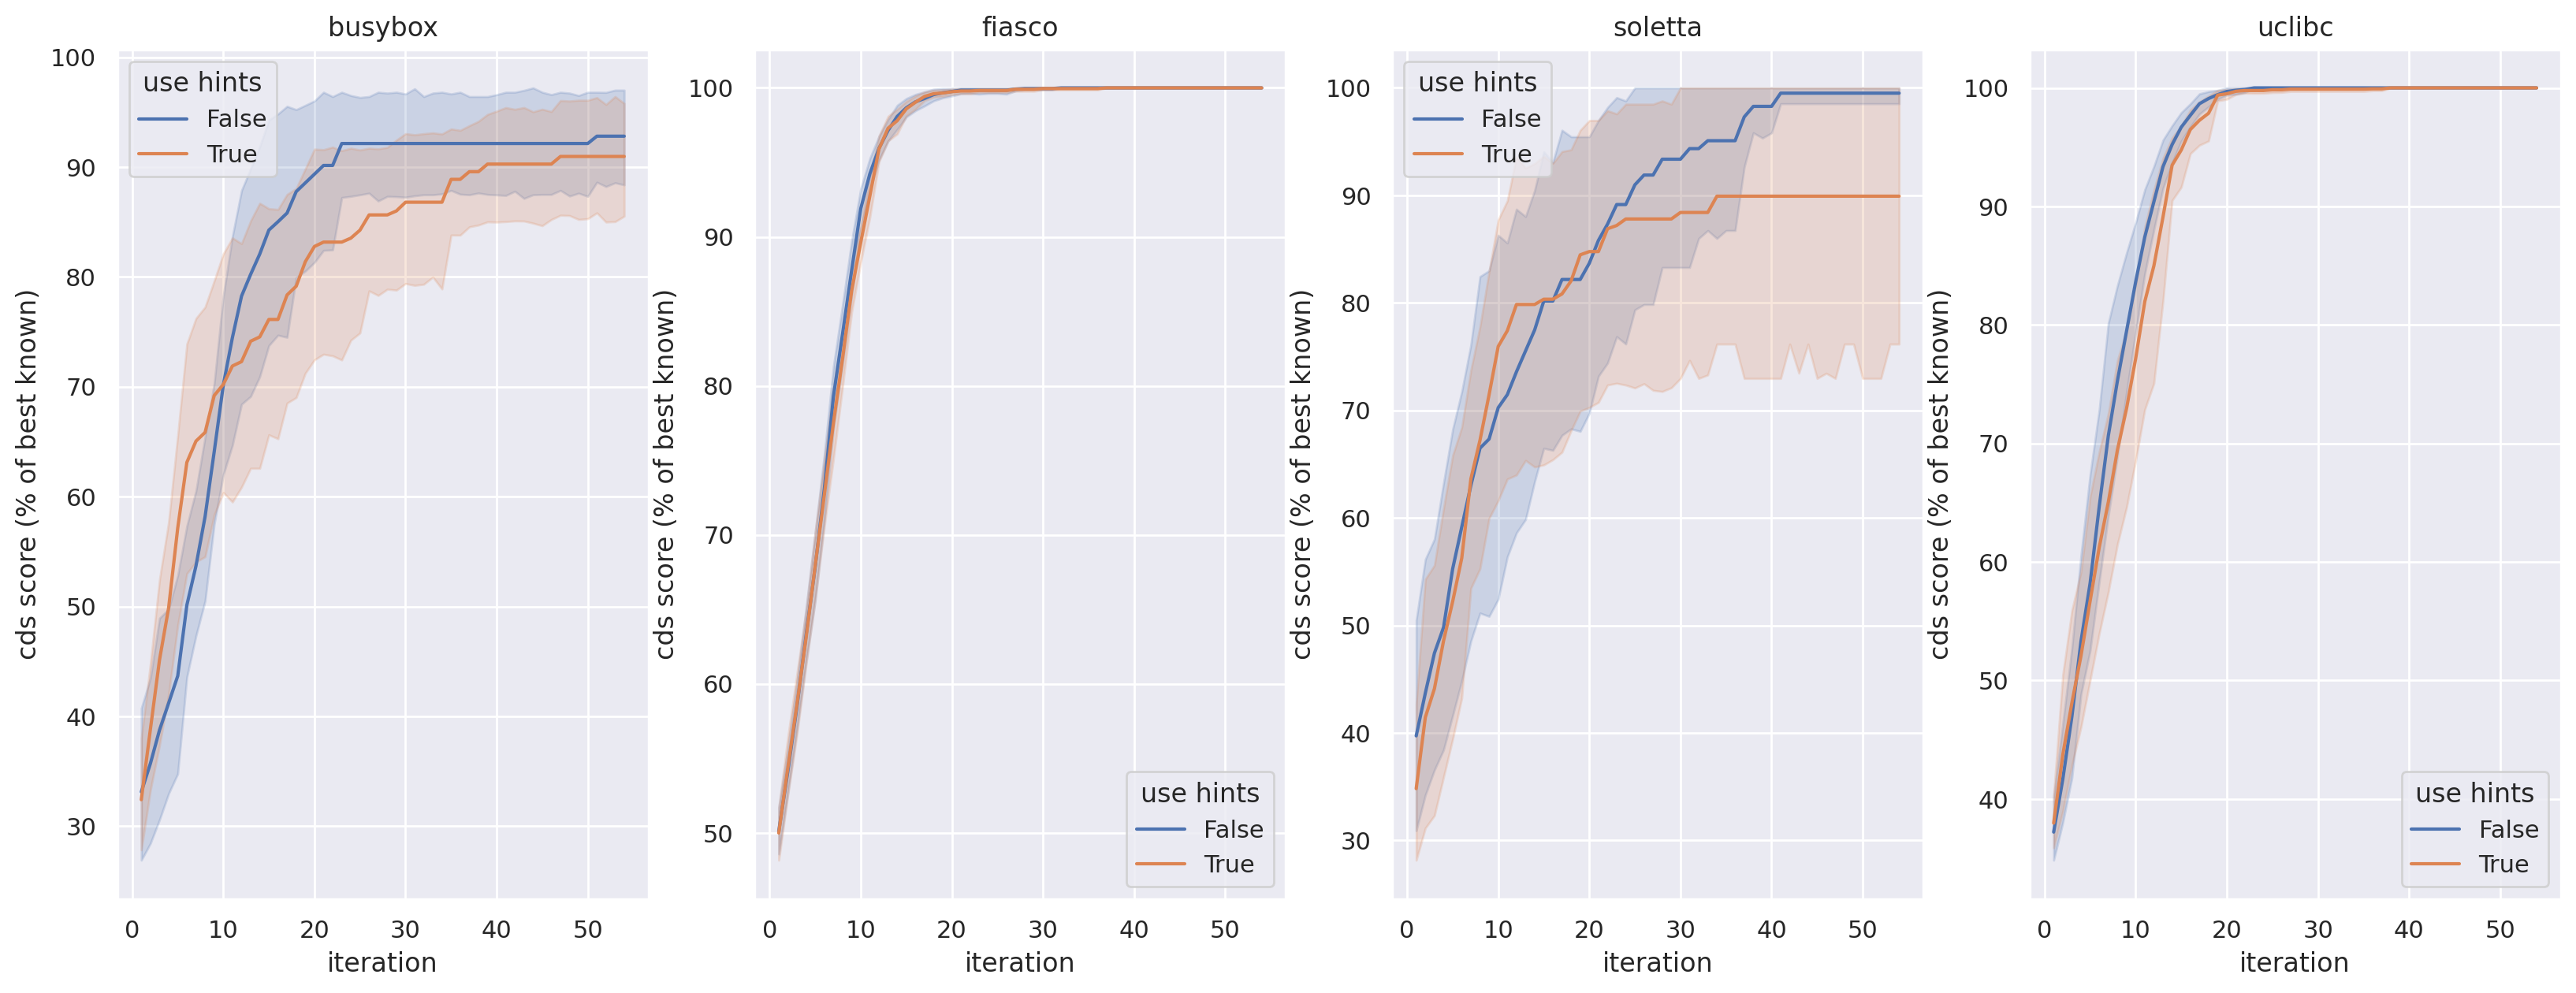

In [12]:
instances = set(data["instance"].map(lambda s: s.split("-")[0]).unique())
instances = instances - set(("toybox",))
print(instances)

plt.cla()
plt.clf()
fig, ax = plt.subplots(1, len(instances))
fig.set_dpi(200)
fig.set_size_inches(len(instances) * 5, 7)

for i, instance in enumerate(sorted(instances)):
    print(i, instance)
    subdata = data[data["instance"].map(lambda s: s.startswith(instance))]
    seaborn.lineplot(data=subdata, ax = ax[i], x="iteration", y="cds score (% of best known)", hue="use hints").set_title(instance)

plt.savefig(f"{instance}_comparison.pdf", bbox_inches='tight')

In [8]:
# molten_data = dict()

# for instance, data in datapoints.items():
#     df_o = pd.DataFrame(data)
#     molten_data[instance] = df_o.melt(["instance", "iteration", "force number of free edges"], var_name="variable", value_name="cds score")

In [9]:
# plt.cla()
# plt.clf()

# for instance, df in molten_data.items():
#     plt.cla()
#     plt.clf()
#     fig, ax = plt.subplots(2,1)
#     fig.set_dpi(200)
#     fig.set_size_inches(12, 10)

#     seaborn.lineplot(data=df, ax = ax[0], x="iteration", y="number of edges", style="variable", style_order=["global cds size", "cds size", "free edges"], hue="adaptive sequential fixing").set_title(instance)
#     seaborn.lineplot(data=df, ax = ax[1], x="iteration", y="number of edges", style="variable", style_order=["nbhd_time", "ip_time"], hue="adaptive sequential fixing")
#     plt.ylabel("time in seconds")
#     plt.savefig(f"{instance}_comparison.pdf", bbox_inches='tight')
#     print(instance)

In [10]:
# import zipfile

# INSTANCE_ZIP_PATH = "/home/gabriel/git/software-configuration-problem-cpp/instances/exported_instances.zip"
# def get_instance_archive() -> zipfile.ZipFile:
#     return zipfile.ZipFile(INSTANCE_ZIP_PATH, "r")


# def get_instance_names():
#     with get_instance_archive() as archive:
#         return [f.filename.split("/")[0] for f in archive.filelist if f.is_dir()]

# instances = get_instance_names()

# num_vertices = defaultdict(list)
# num_edges = defaultdict(list)
# with get_instance_archive() as archive:
#     for instance in instances:
#         n_concrete = int(
#             json.loads(archive.read(f"{instance}/index_instance.json"))["n_concrete"]
#         )
#         num_vertices[instance[:4]].append(n_concrete * 2)
#         conflicts = json.loads(archive.read(f"{instance}/conflicts.json"))["conflicts"]
#         num_edges[instance[:4]].append((n_concrete * 2)**2 - len(conflicts))
#         # # initial_sol = json.loads(archive.read(f"{instance}/initial.json"))["initial_mutually_exclusive_set"]
#         # assert type(conflicts) == list
#         # assert len(conflicts) > 0
#         # assert type(initial_sol) == list
#         # # assert len(initial_sol) > 0
#         # assert n_concrete > 0

# for key in num_vertices.keys():
#     l1 = num_vertices[key]
#     l2 = num_edges[key]

#     print(f"{key}: #nodes: min = {min(l1)}, max = {max(l1)}, avg = {sum(l1) / len(l1)}")
#     print(f"{key}: #edges: min = {min(l2)}, max = {max(l2)}, avg = {sum(l2) / len(l2)}")